### Deskripsi Singkat

Kode ini membangun sebuah model prediksi resesi ekonomi menggunakan Recurrent Neural Network (RNN) dengan arsitektur SimpleRNN. Program ini menganalisis data finansial historis (GDP Growth, Inflation Rate, Money Supply, Government Debt) untuk memprediksi kemungkinan terjadinya resesi di masa depan, termasuk membuat proyeksi untuk 30 tahun ke depan.

### Alasan Menggunakan RNN

1. Menggunakan RNN yang cocok untuk data time series
2. Penanganan class imbalance yang adaptif
3. Evaluasi komprehensif dengan berbagai metrik
4. Visualisasi yang informatif untuk analisis prediksi
5. Simulasi perubahan fitur yang realistis untuk prediksi jangka panjang

### Pendekatan (Approach)

1. **Data Loading dan Preprocessing**:
    - Memuat dataset finansial global
    - Membersihkan data dengan menghapus baris yang mengandung nilai null
    - Melakukan normalisasi fitur menggunakan MinMaxScaler
2. **Analisis Eksplorasi Data**:
    - Visualisasi distribusi kelas target (resesi/tidak resesi)
    - Analisis hubungan antara GDP Growth dan resesi
    - Heatmap korelasi antar fitur
3. **Penanganan Class Imbalance**:
    - Menggunakan RandomOverSampler untuk menangani ketidakseimbangan kelas
    - Hanya melakukan oversampling jika kelas minoritas < 20%
4. **Pembentukan Sequences**:
    - Membuat sequences data dengan time steps=3 untuk model RNN
    - Setiap sequence terdiri dari data 3 tahun berturut-turut
5. **Pemodelan RNN**:
    - Arsitektur: Dua layer SimpleRNN dengan dropout untuk regularisasi
    - Layer pertama (128 unit) dengan return_sequences=True
    - Layer kedua (64 unit)
    - Layer Dense akhir dengan aktivasi sigmoid untuk klasifikasi biner
    - Menggunakan Adam optimizer dengan learning rate 0.001
6. **Training dan Evaluasi**:
    - Early stopping untuk mencegah overfitting
    - Monitoring val_loss dengan patience=20
    - Evaluasi menggunakan accuracy, precision, dan recall
    - Confusion matrix dan classification report untuk analisis performa
7. **Prediksi Masa Depan**:
    - Membuat proyeksi 30 tahun ke depan
    - Menggunakan data terakhir sebagai seed untuk prediksi beruntun
    - Mensimulasikan perubahan fitur dengan noise acak
    - Visualisasi prediksi GDP Growth dan tahun-tahun resesi
8. **Visualisasi**:
    - Plot tren historis dan prediksi
    - Penanda tahun-tahun resesi (historis dan prediksi)
    - Tampilan probabilitas resesi untuk tahun prediksi

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler

Kode tersebut mengimpor berbagai pustaka untuk analisis data, visualisasi, dan pembuatan model deep learning. numpy, pandas, matplotlib, dan seaborn digunakan untuk manipulasi dan visualisasi data, sementara tensorflow dan keras digunakan untuk membangun model RNN. MinMaxScaler digunakan untuk normalisasi data, train_test_split untuk membagi data latih dan uji, serta metrik seperti confusion_matrix dan accuracy_score untuk evaluasi model. Model dibangun menggunakan arsitektur Sequential dengan layer SimpleRNN, Dense, dan Dropout, dioptimasi dengan Adam. EarlyStopping digunakan untuk mencegah overfitting, sedangkan class_weight dan RandomOverSampler membantu mengatasi ketidakseimbangan kelas.

In [22]:
# 1. Load dan Preprocess Data
print("=== LANGKAH 1: LOAD DAN PREPROCESS DATA ===")
df = pd.read_csv("global_financial_.csv")

# Filter data
columns_to_check = ['Year', 'GDP_Growth', 'Inflation_Rate', 'M2_Money_Supply', 'Government_Debt', 'Recession']
df = df.dropna(subset=columns_to_check)
print("\n5 data pertama:")
df.head()

=== LANGKAH 1: LOAD DAN PREPROCESS DATA ===

5 data pertama:


,Year,GDP_Growth,Inflation_Rate,M2_Money_Supply,Government_Debt,Recession
8,1966,4731.888,31.88,462.0,320999.0,0
9,1967,4870.299,32.90,481.6,330947.0,0
10,1968,5057.553,34.10,527.4,349473.0,0
11,1969,5283.597,35.70,569.3,359546.0,0
12,1970,5300.652,37.90,589.6,372007.0,1



=== LANGKAH 2: ANALISIS DATA ===


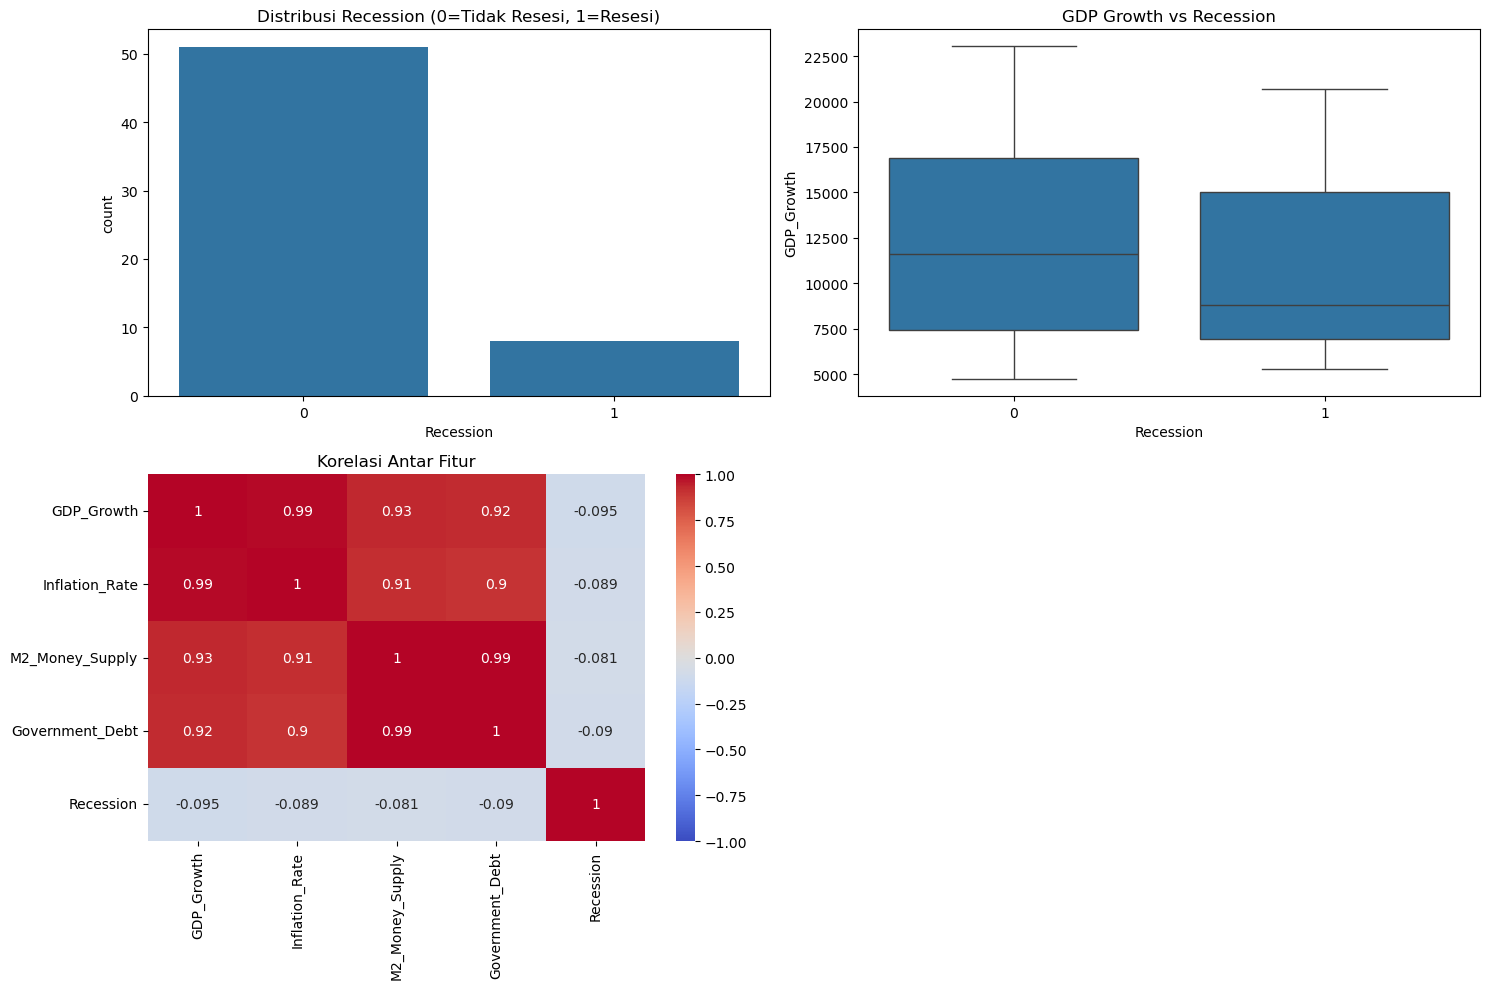

In [30]:
# 2. Analisis Data
print("\n=== LANGKAH 2: ANALISIS DATA ===")
plt.figure(figsize=(15, 10))

# Distribusi Recession
plt.subplot(2, 2, 1)
sns.countplot(x='Recession', data=df)
plt.title('Distribusi Recession (0=Tidak Resesi, 1=Resesi)')

# GDP Growth vs Recession
plt.subplot(2, 2, 2)
sns.boxplot(x='Recession', y='GDP_Growth', data=df)
plt.title('GDP Growth vs Recession')

# Korelasi antar fitur
plt.subplot(2, 2, 3)
corr_matrix = df[['GDP_Growth', 'Inflation_Rate', 'M2_Money_Supply', 'Government_Debt', 'Recession']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasi Antar Fitur')

plt.tight_layout()
plt.show()

Blok ini melakukan analisis eksploratif data untuk memahami pola dan hubungan antar variabel. Visualisasi pertama menampilkan distribusi kelas Recession (resesi atau tidak), yang membantu melihat apakah data seimbang. Visualisasi kedua membandingkan GDP_Growth antara kondisi resesi dan tidak menggunakan boxplot. Terakhir, heatmap korelasi digunakan untuk melihat kekuatan dan arah hubungan antar fitur ekonomi seperti GDP_Growth, Inflation_Rate, M2_Money_Supply, dan Government_Debt terhadap variabel target Recession.

In [32]:
# 3. Penanganan Class Imbalance
print("\n=== LANGKAH 3: PENANGANAN CLASS IMBALANCE ===")
print("Distribusi Kelas Awal (Recession):")
print(df['Recession'].value_counts())

features = ['GDP_Growth', 'Inflation_Rate', 'M2_Money_Supply', 'Government_Debt']
X = df[features].values
y = df['Recession'].values  # Menggunakan kolom Recession sebagai target

# Oversampling jika kelas minoritas < 20%
if df['Recession'].mean() < 0.2:
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X, y)
    print("\nSetelah Oversampling:")
    print(pd.Series(y_res).value_counts())
else:
    X_res, y_res = X, y


=== LANGKAH 3: PENANGANAN CLASS IMBALANCE ===
Distribusi Kelas Awal (Recession):
Recession
0    51
1     8
Name: count, dtype: int64

Setelah Oversampling:
0    51
1    51
Name: count, dtype: int64


Blok ini melakukan analisis eksploratif data untuk memahami pola dan hubungan antar variabel. Visualisasi pertama menampilkan distribusi kelas Recession (resesi atau tidak), yang membantu melihat apakah data seimbang. Visualisasi kedua membandingkan GDP_Growth antara kondisi resesi dan tidak menggunakan boxplot. Terakhir, heatmap korelasi digunakan untuk melihat kekuatan dan arah hubungan antar fitur ekonomi seperti GDP_Growth, Inflation_Rate, M2_Money_Supply, dan Government_Debt terhadap variabel target Recession.

In [34]:
# 4. Preprocessing Data
print("\n=== LANGKAH 4: PREPROCESSING DATA ===")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_res)

# Membuat sequences dengan time steps
time_steps = 3
X_sequences = []
y_sequences = []

for i in range(time_steps, len(X_scaled)):
    X_sequences.append(X_scaled[i-time_steps:i])
    y_sequences.append(y_res[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


=== LANGKAH 4: PREPROCESSING DATA ===


Blok ini melakukan analisis eksploratif data untuk memahami pola dan hubungan antar variabel. Visualisasi pertama menampilkan distribusi kelas Recession (resesi atau tidak), yang membantu melihat apakah data seimbang. Visualisasi kedua membandingkan GDP_Growth antara kondisi resesi dan tidak menggunakan boxplot. Terakhir, heatmap korelasi digunakan untuk melihat kekuatan dan arah hubungan antar fitur ekonomi seperti GDP_Growth, Inflation_Rate, M2_Money_Supply, dan Government_Debt terhadap variabel target Recession.

In [36]:
# 5. Split Data
print("\n=== LANGKAH 5: SPLIT DATA ===")
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, 
                                                   test_size=0.2, 
                                                   random_state=42,
                                                   shuffle=True)


=== LANGKAH 5: SPLIT DATA ===


Blok ini melakukan analisis eksploratif data untuk memahami pola dan hubungan antar variabel. Visualisasi pertama menampilkan distribusi kelas Recession (resesi atau tidak), yang membantu melihat apakah data seimbang. Visualisasi kedua membandingkan GDP_Growth antara kondisi resesi dan tidak menggunakan boxplot. Terakhir, heatmap korelasi digunakan untuk melihat kekuatan dan arah hubungan antar fitur ekonomi seperti GDP_Growth, Inflation_Rate, M2_Money_Supply, dan Government_Debt terhadap variabel target Recession.

In [7]:
# 6. Bangun Model RNN
print("\n=== LANGKAH 6: MEMBANGUN MODEL RNN ===")
model = Sequential([
    SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences=True, activation='tanh'),
    Dropout(0.3),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

model.summary()


=== LANGKAH 6: MEMBANGUN MODEL RNN ===


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 3, 128)         │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,489 (123.00 KB)

 Trainable params: 31,489 (123.00 KB)

 Non-trainable params: 0 (0.00 B)

Blok ini melakukan analisis eksploratif data untuk memahami pola dan hubungan antar variabel. Visualisasi pertama menampilkan distribusi kelas Recession (resesi atau tidak), yang membantu melihat apakah data seimbang. Visualisasi kedua membandingkan GDP_Growth antara kondisi resesi dan tidak menggunakan boxplot. Terakhir, heatmap korelasi digunakan untuk melihat kekuatan dan arah hubungan antar fitur ekonomi seperti GDP_Growth, Inflation_Rate, M2_Money_Supply, dan Government_Debt terhadap variabel target Recession.

In [38]:
# 7. Training Model
print("\n=== LANGKAH 7: TRAINING MODEL ===")
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


=== LANGKAH 7: TRAINING MODEL ===
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9263 - loss: 0.3016 - precision: 1.0000 - recall: 0.8533 - val_accuracy: 0.7500 - val_loss: 0.4723 - val_precision: 1.0000 - val_recall: 0.6364
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8738 - loss: 0.3299 - precision: 1.0000 - recall: 0.7514 - val_accuracy: 0.7500 - val_loss: 0.5120 - val_precision: 1.0000 - val_recall: 0.6364
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8737 - loss: 0.2695 - precision: 0.9733 - recall: 0.7661 - val_accuracy: 0.7500 - val_loss: 0.5197 - val_precision: 1.0000 - val_recall: 0.6364
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8737 - loss: 0.3173 - precision: 1.0000 - recall: 0.7391 - val_accuracy: 0.7500 - val_loss: 0.5167 - val_precision: 1.0000 - val_recall: 0.6364
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8737 - loss: 0.2890 - precision: 1.0000 - recall: 0.7327 - val_accura

Blok ini melakukan analisis eksploratif data untuk memahami pola dan hubungan antar variabel. Visualisasi pertama menampilkan distribusi kelas Recession (resesi atau tidak), yang membantu melihat apakah data seimbang. Visualisasi kedua membandingkan GDP_Growth antara kondisi resesi dan tidak menggunakan boxplot. Terakhir, heatmap korelasi digunakan untuk melihat kekuatan dan arah hubungan antar fitur ekonomi seperti GDP_Growth, Inflation_Rate, M2_Money_Supply, dan Government_Debt terhadap variabel target Recession.


=== LANGKAH 8: EVALUASI MODEL ===


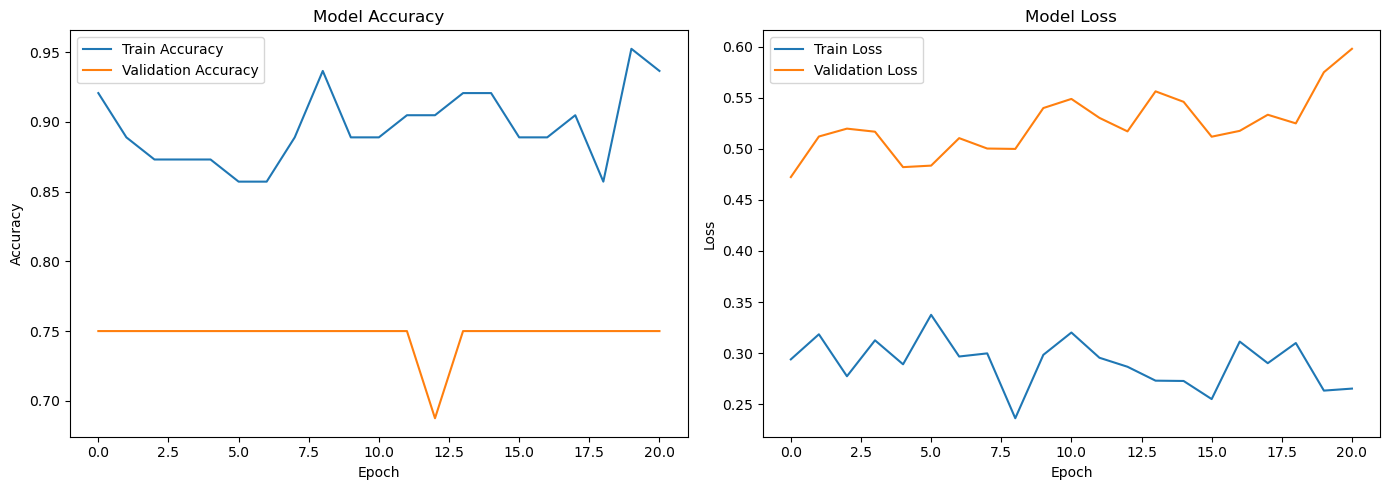

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


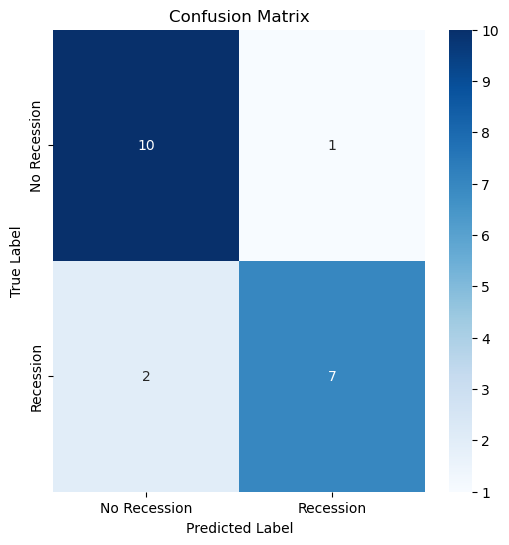


Classification Report:
              precision    recall  f1-score   support

No Recession       0.83      0.91      0.87        11
   Recession       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



In [40]:
# 8. Evaluasi Model
print("\n=== LANGKAH 8: EVALUASI MODEL ===")
# Plot akurasi dan loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Prediksi dan Confusion Matrix
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Recession', 'Recession'],
            yticklabels=['No Recession', 'Recession'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Recession', 'Recession']))

Blok ini melakukan analisis eksploratif data untuk memahami pola dan hubungan antar variabel. Visualisasi pertama menampilkan distribusi kelas Recession (resesi atau tidak), yang membantu melihat apakah data seimbang. Visualisasi kedua membandingkan GDP_Growth antara kondisi resesi dan tidak menggunakan boxplot. Terakhir, heatmap korelasi digunakan untuk melihat kekuatan dan arah hubungan antar fitur ekonomi seperti GDP_Growth, Inflation_Rate, M2_Money_Supply, dan Government_Debt terhadap variabel target Recession.

In [42]:
# 9. Prediksi 30 Tahun ke Depan
print("\n=== LANGKAH 9: PREDIKSI 30 TAHUN KE DEPAN ===")
last_year = df['Year'].max()
future_years = range(last_year + 1, last_year + 31)

# Gunakan data terakhir sebagai seed
current_sequence = X_scaled[-time_steps:].reshape(1, time_steps, len(features))

predictions = []
recession_probs = []

for year in future_years:
    # Prediksi probabilitas resesi
    recession_prob = model.predict(current_sequence, verbose=0)[0][0]
    recession_probs.append(recession_prob)
    
    # Prediksi fitur untuk tahun berikutnya (sederhana)
    last_features = current_sequence[0, -1, :].copy()
    
    # Simulasi perubahan fitur
    last_features[0] = np.clip(last_features[0] + np.random.normal(0, 0.03), 0, 1)  # GDP
    last_features[1] = np.clip(last_features[1] + np.random.normal(0, 0.05), 0, 1)  # Inflasi
    last_features[2] = np.clip(last_features[2] + np.random.normal(0.02, 0.03), 0, 1)  # Money Supply
    last_features[3] = np.clip(last_features[3] + np.random.normal(0.03, 0.02), 0, 1)  # Debt
    
    # Update sequence
    new_sequence = np.append(current_sequence[0, 1:, :], [last_features], axis=0)
    current_sequence = new_sequence.reshape(1, time_steps, len(features))
    
    predictions.append(last_features)

predictions = np.array(predictions)

# Konversi ke nilai asli
predicted_values = scaler.inverse_transform(predictions)
recession_years = [year for year, prob in zip(future_years, recession_probs) if prob > 0.5]


=== LANGKAH 9: PREDIKSI 30 TAHUN KE DEPAN ===


Blok ini melakukan analisis eksploratif data untuk memahami pola dan hubungan antar variabel. Visualisasi pertama menampilkan distribusi kelas Recession (resesi atau tidak), yang membantu melihat apakah data seimbang. Visualisasi kedua membandingkan GDP_Growth antara kondisi resesi dan tidak menggunakan boxplot. Terakhir, heatmap korelasi digunakan untuk melihat kekuatan dan arah hubungan antar fitur ekonomi seperti GDP_Growth, Inflation_Rate, M2_Money_Supply, dan Government_Debt terhadap variabel target Recession.


=== LANGKAH 10: VISUALISASI PREDIKSI ===


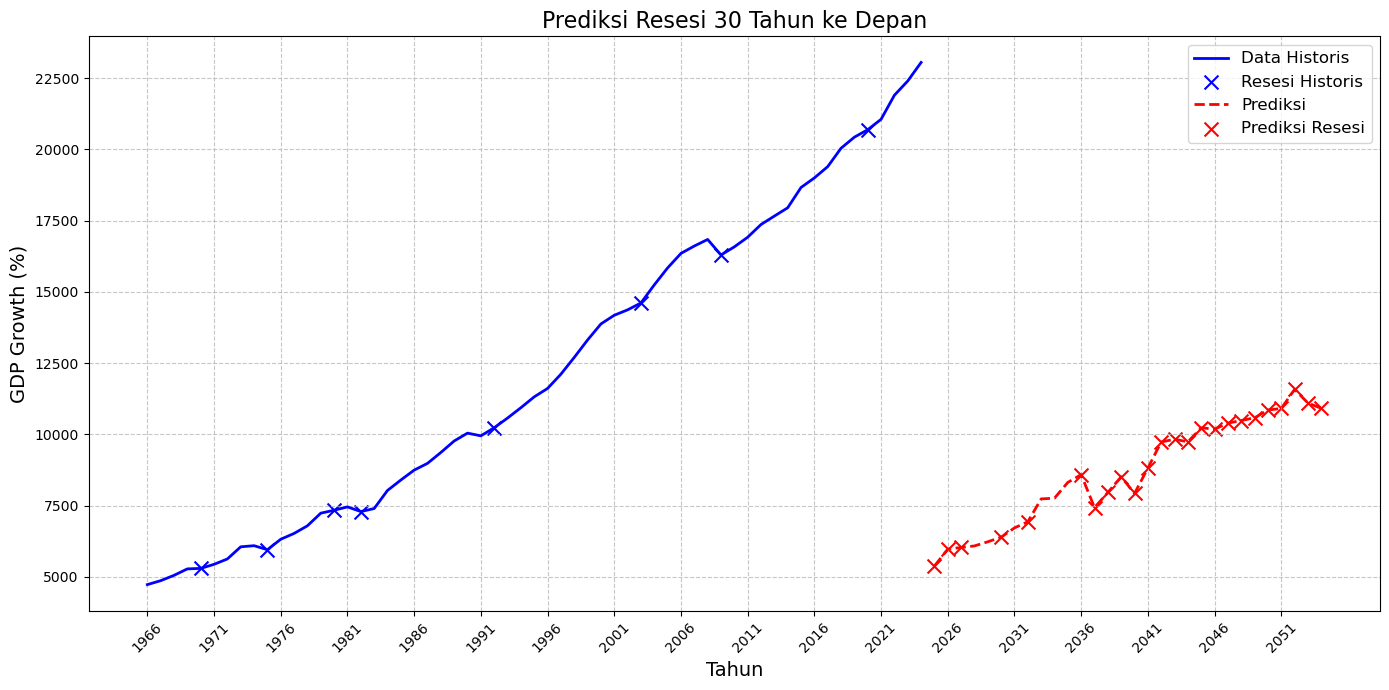

In [11]:
# 10. Visualisasi Prediksi
print("\n=== LANGKAH 10: VISUALISASI PREDIKSI ===")
plt.figure(figsize=(14, 7))

# Plot data historis
plt.plot(df['Year'], df['GDP_Growth'], 'b-', label='Data Historis', linewidth=2)
# Tandai resesi historis
recession_data = df[df['Recession'] == 1]
plt.scatter(recession_data['Year'], recession_data['GDP_Growth'], 
           color='blue', s=100, label='Resesi Historis', marker='x')

# Plot prediksi
plt.plot(future_years, predicted_values[:, 0], 'r--', label='Prediksi', linewidth=2)
# Tandai prediksi resesi
if recession_years:
    recession_indices = [list(future_years).index(year) for year in recession_years]
    plt.scatter(recession_years, [predicted_values[i, 0] for i in recession_indices],
               color='red', s=100, label='Prediksi Resesi', marker='x')

plt.title('Prediksi Resesi 30 Tahun ke Depan', fontsize=16)
plt.xlabel('Tahun', fontsize=14)
plt.ylabel('GDP Growth (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis
all_years = list(df['Year']) + list(future_years)
plt.xticks(np.arange(min(all_years), max(all_years)+1, 5), rotation=45)

plt.tight_layout()
plt.show()

Blok ini melakukan analisis eksploratif data untuk memahami pola dan hubungan antar variabel. Visualisasi pertama menampilkan distribusi kelas Recession (resesi atau tidak), yang membantu melihat apakah data seimbang. Visualisasi kedua membandingkan GDP_Growth antara kondisi resesi dan tidak menggunakan boxplot. Terakhir, heatmap korelasi digunakan untuk melihat kekuatan dan arah hubungan antar fitur ekonomi seperti GDP_Growth, Inflation_Rate, M2_Money_Supply, dan Government_Debt terhadap variabel target Recession.

In [44]:
# 11. Hasil Prediksi
print("\n=== HASIL PREDIKSI RESESI 30 TAHUN KE DEPAN ===")
if recession_years:
    print("Tahun-tahun prediksi resesi:")
    for year in recession_years:
        idx = list(future_years).index(year)
        print(f"- {year}: Probabilitas Resesi = {recession_probs[idx]:.2%}, GDP Growth Prediksi = {predicted_values[idx, 0]:.2f}%")
else:
    print("Tidak ada prediksi resesi dalam 30 tahun ke depan")


=== HASIL PREDIKSI RESESI 30 TAHUN KE DEPAN ===
Tahun-tahun prediksi resesi:
- 2025: Probabilitas Resesi = 99.75%, GDP Growth Prediksi = 5702.38%
- 2026: Probabilitas Resesi = 99.63%, GDP Growth Prediksi = 5446.12%
- 2028: Probabilitas Resesi = 58.05%, GDP Growth Prediksi = 5197.12%
- 2029: Probabilitas Resesi = 84.24%, GDP Growth Prediksi = 4811.12%
- 2030: Probabilitas Resesi = 68.40%, GDP Growth Prediksi = 4947.49%
- 2031: Probabilitas Resesi = 62.91%, GDP Growth Prediksi = 4814.21%
- 2032: Probabilitas Resesi = 80.86%, GDP Growth Prediksi = 5025.43%
- 2033: Probabilitas Resesi = 81.62%, GDP Growth Prediksi = 4731.89%
- 2034: Probabilitas Resesi = 82.77%, GDP Growth Prediksi = 4731.89%
- 2035: Probabilitas Resesi = 81.18%, GDP Growth Prediksi = 4731.89%
- 2036: Probabilitas Resesi = 78.78%, GDP Growth Prediksi = 4731.89%
- 2037: Probabilitas Resesi = 90.18%, GDP Growth Prediksi = 4731.89%
- 2038: Probabilitas Resesi = 84.35%, GDP Growth Prediksi = 4731.89%
- 2039: Probabilitas Rese

Blok ini melakukan analisis eksploratif data untuk memahami pola dan hubungan antar variabel. Visualisasi pertama menampilkan distribusi kelas Recession (resesi atau tidak), yang membantu melihat apakah data seimbang. Visualisasi kedua membandingkan GDP_Growth antara kondisi resesi dan tidak menggunakan boxplot. Terakhir, heatmap korelasi digunakan untuk melihat kekuatan dan arah hubungan antar fitur ekonomi seperti GDP_Growth, Inflation_Rate, M2_Money_Supply, dan Government_Debt terhadap variabel target Recession.